### Import Libraries

In [2]:
from pathlib import Path
import shutil
import os
import logging
import sys
import gc
sys.path.append('C:/Users/KAPLAN/Desktop/pytorch_examples/models/')
from pandas import DataFrame
from textblob import TextBlob
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

import time
from transformers import AutoModelForSequenceClassification

from finbert.finbert import *
import finbert.utils as tools

%load_ext autoreload
%autoreload 2

project_dir = Path.cwd().parent
pd.set_option('max_colwidth', -1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KAPLAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-2-a0746e54ffe7>:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [3]:
project_dir

WindowsPath('C:/Users/KAPLAN/Desktop')

In [4]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.ERROR)

In [5]:
lm_path = project_dir/'pytorch_examples'/'models'/'language_model'/'finbertTRC2'
cl_path = project_dir/'pytorch_examples'/'models'/'classifier_model'/'finbert_sentiment'
cl_data_path = project_dir/'pytorch_examples'/'models'/'data'/'sentiment_data'

## Configuring adapted functions

In [6]:
def oneHot(row):
  if row=='negative': return -1
  if row=='neutral' : return  0
  if row=='positive' : return +1

In [51]:
def predict(text, model, write_to_csv=False, path=None):
    """
    Predict sentiments of sentences in a given text. The function first tokenizes sentences, make predictions and write
    results.
    Parameters
    ----------
    text: string
        text to be analyzed
    model: BertForSequenceClassification
        path to the classifier model
    write_to_csv (optional): bool
    path (optional): string
        path to write the string
    """
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    sentences = text   
    label_list = ['positive', 'negative', 'neutral']
    label_dict = {0: 'positive', 1: 'negative', 2: 'neutral'}
    result = pd.DataFrame(columns=['sentence', 'logit', 'prediction', 'sentiment_score'])
    for batch in chunks(text, len(text)):
        examples = [InputExample(str(i), sentence) for i, sentence in enumerate(batch)]

        features = convert_examples_to_features(examples, label_list, 64, tokenizer)

        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)

        with torch.no_grad():
            logits = model(all_input_ids, all_attention_mask, all_token_type_ids)[0]
            logging.info(logits)
            logits = softmax(np.array(logits))
            sentiment_score = pd.Series(logits[:, 0] - logits[:, 1])
            predictions = np.squeeze(np.argmax(logits, axis=1))

            batch_result = {'sentence': batch,
                            'logit': list(logits),
                            'prediction': predictions,
                            'sentiment_score': sentiment_score}

            batch_result = pd.DataFrame(batch_result)
            result = pd.concat([result, batch_result], ignore_index=True)

    result['prediction'] = result.prediction.apply(lambda x: label_dict[x])
    if write_to_csv:
        result.to_csv(path, sep=',', index=True)

    return result

## Configuring training parameters

In [8]:
# Clean the cl_path
try:
    shutil.rmtree(cl_path) 
except:
    pass

bertmodel = AutoModelForSequenceClassification.from_pretrained(lm_path,cache_dir=None, num_labels=3)


config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=4,
                   model_dir=cl_path,
                   max_seq_length = 48,
                   train_batch_size = 32,
                   learning_rate = 2e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True)

In [9]:
finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

In [10]:
finbert.prepare_model(label_list=['positive','negative','neutral'])
class_names = ['positive','negative','neutral']

06/30/2021 16:21:50 - INFO - finbert.finbert -   device: cpu n_gpu: 0, distributed training: False, 16-bits training: False


In [11]:
train_data = finbert.get_data('train')

In [12]:
model = finbert.create_the_model()

In [13]:
from finbert.finbert import *
trained_model = finbert.train(train_examples = train_data, model = model)

06/30/2021 16:21:57 - INFO - finbert.utils -   *** Example ***
06/30/2021 16:21:57 - INFO - finbert.utils -   guid: train-1
06/30/2021 16:21:57 - INFO - finbert.utils -   tokens: [CLS] vietnam 1 ##q crude - oil exports down 17 . 4 % on year at 1 . 82 ##m tons - customs [SEP]
06/30/2021 16:21:57 - INFO - finbert.utils -   input_ids: 101 5148 1015 4160 13587 1011 3514 14338 2091 2459 1012 1018 1003 2006 2095 2012 1015 1012 6445 2213 6197 1011 8205 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:21:57 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:21:57 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:21:57 - INFO - finbert.utils -   label: positive (id = 0)
06/30/2021 16:21:58 - INFO - finbert.finbert -   ***** Loading data *****
06/30/2021 16:21:58 - INFO - finbe

06/30/2021 16:33:15 - INFO - finbert.utils -   *** Example ***
06/30/2021 16:33:15 - INFO - finbert.utils -   guid: validation-1
06/30/2021 16:33:15 - INFO - finbert.utils -   tokens: [CLS] doe : us crude oil stocks - 4 . 61 ##7 ml ##n bb ##l at 425 . 332 ml ##n bb ##l [SEP]
06/30/2021 16:33:15 - INFO - finbert.utils -   input_ids: 101 18629 1024 2149 13587 3514 15768 1011 1018 1012 6079 2581 19875 2078 22861 2140 2012 23285 1012 29327 19875 2078 22861 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:33:15 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:33:15 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:33:15 - INFO - finbert.utils -   label: positive (id = 0)


06/30/2021 16:33:15 - INFO - finbert.finbert -   ***** Loading data *****
06/30/2021 16:33:15 - INFO - finbert.finbert -     Num examples = 3956
06/30/2021 16:33:15 - INFO - finbert.finbert -     Batch size = 32
06/30/2021 16:33:15 - INFO - finbert.finbert -     Num steps = 492



Validation losses: [0.3026972360488388]
No best model found


Epoch:  25%|██▌       | 1/4 [13:44<41:12, 824.23s/it]

06/30/2021 16:51:41 - INFO - finbert.utils -   *** Example ***
06/30/2021 16:51:41 - INFO - finbert.utils -   guid: validation-1
06/30/2021 16:51:41 - INFO - finbert.utils -   tokens: [CLS] doe : us crude oil stocks - 4 . 61 ##7 ml ##n bb ##l at 425 . 332 ml ##n bb ##l [SEP]
06/30/2021 16:51:41 - INFO - finbert.utils -   input_ids: 101 18629 1024 2149 13587 3514 15768 1011 1018 1012 6079 2581 19875 2078 22861 2140 2012 23285 1012 29327 19875 2078 22861 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:51:41 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:51:41 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 16:51:41 - INFO - finbert.utils -   label: positive (id = 0)


06/30/2021 16:51:41 - INFO - finbert.finbert -   ***** Loading data *****
06/30/2021 16:51:41 - INFO - finbert.finbert -     Num examples = 3956
06/30/2021 16:51:41 - INFO - finbert.finbert -     Batch size = 32
06/30/2021 16:51:41 - INFO - finbert.finbert -     Num steps = 492



Validation losses: [0.3026972360488388, 0.0976397918627387]


Epoch:  50%|█████     | 2/4 [32:08<30:16, 908.18s/it]

06/30/2021 17:15:10 - INFO - finbert.utils -   *** Example ***
06/30/2021 17:15:10 - INFO - finbert.utils -   guid: validation-1
06/30/2021 17:15:10 - INFO - finbert.utils -   tokens: [CLS] doe : us crude oil stocks - 4 . 61 ##7 ml ##n bb ##l at 425 . 332 ml ##n bb ##l [SEP]
06/30/2021 17:15:10 - INFO - finbert.utils -   input_ids: 101 18629 1024 2149 13587 3514 15768 1011 1018 1012 6079 2581 19875 2078 22861 2140 2012 23285 1012 29327 19875 2078 22861 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:15:10 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:15:10 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:15:10 - INFO - finbert.utils -   label: positive (id = 0)


06/30/2021 17:15:10 - INFO - finbert.finbert -   ***** Loading data *****
06/30/2021 17:15:10 - INFO - finbert.finbert -     Num examples = 3956
06/30/2021 17:15:10 - INFO - finbert.finbert -     Batch size = 32
06/30/2021 17:15:10 - INFO - finbert.finbert -     Num steps = 492



Validation losses: [0.3026972360488388, 0.0976397918627387, 0.08612998336884042]


Epoch:  75%|███████▌  | 3/4 [55:40<17:39, 1059.27s/it]

06/30/2021 17:41:30 - INFO - finbert.utils -   *** Example ***
06/30/2021 17:41:30 - INFO - finbert.utils -   guid: validation-1
06/30/2021 17:41:30 - INFO - finbert.utils -   tokens: [CLS] doe : us crude oil stocks - 4 . 61 ##7 ml ##n bb ##l at 425 . 332 ml ##n bb ##l [SEP]
06/30/2021 17:41:30 - INFO - finbert.utils -   input_ids: 101 18629 1024 2149 13587 3514 15768 1011 1018 1012 6079 2581 19875 2078 22861 2140 2012 23285 1012 29327 19875 2078 22861 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:41:30 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:41:30 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:41:30 - INFO - finbert.utils -   label: positive (id = 0)


06/30/2021 17:41:30 - INFO - finbert.finbert -   ***** Loading data *****
06/30/2021 17:41:30 - INFO - finbert.finbert -     Num examples = 3956
06/30/2021 17:41:30 - INFO - finbert.finbert -     Batch size = 32
06/30/2021 17:41:30 - INFO - finbert.finbert -     Num steps = 492



Validation losses: [0.3026972360488388, 0.0976397918627387, 0.08612998336884042, 0.08424124569677177]


Epoch: 100%|██████████| 4/4 [1:21:59<00:00, 1229.89s/it]


In [14]:
test_data = finbert.get_data('test')

In [15]:
results = finbert.evaluate(examples=test_data, model=trained_model)

06/30/2021 17:45:23 - INFO - finbert.utils -   *** Example ***
06/30/2021 17:45:23 - INFO - finbert.utils -   guid: test-1
06/30/2021 17:45:23 - INFO - finbert.utils -   tokens: [CLS] api : us crude stocks d ##n 3 . 09 ##2 million bb ##l in week [SEP]
06/30/2021 17:45:23 - INFO - finbert.utils -   input_ids: 101 17928 1024 2149 13587 15768 1040 2078 1017 1012 5641 2475 2454 22861 2140 1999 2733 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:45:23 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:45:23 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 17:45:23 - INFO - finbert.utils -   label: positive (id = 0)
06/30/2021 17:45:23 - INFO - finbert.finbert -   ***** Loading data *****
06/30/2021 17:45:23 - INFO - finbert.finbert -     Num examples = 3956
06/

In [16]:
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

In [17]:
y_test = results['labels'] 
y_pred = results['prediction']

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    cs = CrossEntropyLoss(weight=finbert.class_weights)
    loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))
    print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    print(classification_report(df[cols[0]], df[cols[1]]))

In [18]:
report(results,cols=['labels','prediction','predictions'])

06/30/2021 17:47:50 - INFO - numexpr.utils -   Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
06/30/2021 17:47:50 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


Loss:0.09
Accuracy:0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1965
           1       0.98      0.98      0.98      1924
           2       0.96      0.97      0.96        67

    accuracy                           0.98      3956
   macro avg       0.97      0.97      0.97      3956
weighted avg       0.98      0.98      0.98      3956



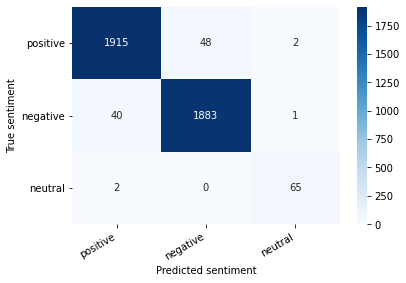

In [19]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Load the pre-trained Model

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(cl_path, cache_dir=None, num_labels=3)

## Or import already pre-trained Model

In [37]:
"""
model_finbert = BertForSequenceClassification.from_pretrained('model_test/pytorch_model.bin',config='model_test/config.json',num_labels=3)
model_crudebert = BertForSequenceClassification.from_pretrained('model_test/crude_bert_model.bin',config='model_test/crude_bert_config.json',num_labels=3)
"""

"\nmodel_finbert = BertForSequenceClassification.from_pretrained('model_test/pytorch_model.bin',config='model_test/config.json',num_labels=3)\nmodel_crudebert = BertForSequenceClassification.from_pretrained('model_test/crude_bert_model.bin',config='model_test/crude_bert_config.json',num_labels=3)\n"

## Save pre-trained Model

In [39]:
import torch

torch_path ="C:/Users/KAPLAN/Desktop/pytorch_examples/models/CrudeBERT_model"
torch.save(model.state_dict(), os.path.join(torch_path, "crudebert_T4.pth"))

# Read Headlines

In [40]:
news = pd.read_excel("news.xlsx",parse_dates=[['Date', 'Time']], engine='openpyxl')

In [41]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KAPLAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
# Clear Ram with gc (garbage collector)

gc.collect()

#del my_array
#del my_object
#gc.collect()

98

### Slice dataframe if it is to big for the RAM

In [43]:
news_text_first_quarter = news.Headline[:int(len(news.Headline)/4)]

In [44]:
news_text_second_quarter = news.Headline[int(len(news.Headline)/4):int(len(news.Headline)/2)]

In [45]:
news_text_third_quarter = news.Headline[int(len(news.Headline)/2):int(len(news.Headline)/4)*3]

In [46]:
news_text_fourth_quarter = news.Headline[int(len(news.Headline)/4)*3:]

### Verify if sum of slices have the same size as the unsliced dataframe

In [47]:
len(news) == len(news_text_first_quarter) + len(news_text_second_quarter) + len(news_text_third_quarter) + len(news_text_fourth_quarter)

True

### Check with a small sample first

In [48]:
sample = news.Headline[:50]

In [49]:
sample

0     India Apr-Nov Oil Imports $6.20B Vs $4.03B; +53.86%                                                                                                                                                 
1     Texaco and Chevron Missed the Boat on Big Stock Gains --- Their Returns Were Stagnant as Oil Prices Soared Amid Mergers Among Rivals ---- By Steve Liesman Staff Reporter of The Wall Street Journal
2     Taiwan CPC Dec Crude Oil Imports 20.4M Bbl, US$23.79/Bbl                                                                                                                                            
3     Midday US Spot Crude: Prices Sink With Crude Futures                                                                                                                                                
4     API: US Crude Stocks Dn 1.568 Mln Bbl In Week                                                                                                                                         

In [52]:
#if TypeError: expected string or bytes-like object -> re-run def predict(text, model, write_to_csv=False, path=None):
start_time = time.time()
df_sample = predict(sample , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/30/2021 18:03:06 - INFO - finbert.utils -   *** Example ***
06/30/2021 18:03:06 - INFO - finbert.utils -   guid: 0
06/30/2021 18:03:06 - INFO - finbert.utils -   tokens: [CLS] india apr - nov oil imports $ 6 . 20 ##b vs $ 4 . 03 ##b ; + 53 . 86 % [SEP]
06/30/2021 18:03:06 - INFO - finbert.utils -   input_ids: 101 2634 19804 1011 13292 3514 17589 1002 1020 1012 2322 2497 5443 1002 1018 1012 6021 2497 1025 1009 5187 1012 6564 1003 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:03:06 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:03:06 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:03:06 - INFO - finbert.utils -   label: None (id = 9090)
06/30/2021 18:03:08 - INFO - 

 Time passed: 4.586670160293579 seconds 


In [53]:
df_sample

,sentence,logit,prediction,sentiment_score
0,India Apr-Nov Oil Imports $6.20B Vs $4.03B; +53.86%,"[0.99143, 0.007201431, 0.001368628]",positive,0.984229
1,Texaco and Chevron Missed the Boat on Big Stock Gains --- Their Returns Were Stagnant as Oil Prices Soared Amid Mergers Among Rivals ---- By Steve Liesman Staff Reporter of The Wall Street Journal,"[0.95674115, 0.04221672, 0.0010420616]",positive,0.914524
2,"Taiwan CPC Dec Crude Oil Imports 20.4M Bbl, US$23.79/Bbl","[0.9530355, 0.044925828, 0.002038634]",positive,0.908110
3,Midday US Spot Crude: Prices Sink With Crude Futures,"[0.0061857277, 0.99313486, 0.0006794133]",negative,-0.986949
4,API: US Crude Stocks Dn 1.568 Mln Bbl In Week,"[0.9970822, 0.0020342732, 0.0008834445]",positive,0.995048
5,Nymex Access Crude Down After 4th Straight Day Of Losses,"[0.0044214576, 0.99454343, 0.0010351299]",negative,-0.990122
6,China's CNPC '99 Crude Output 107.08M MT; Dn 0.3%,"[0.99586415, 0.0017699075, 0.0023658401]",positive,0.994094
7,Late US Spot Crude: Prices Lower After Choppy Day,"[0.0042944127, 0.9945635, 0.0011420498]",negative,-0.990269
8,WSJ(1/7): Texaco Says Oil Find May Hold A Billion Barrels,"[0.0051258565, 0.99401397, 0.0008602149]",negative,-0.988888
9,Nymex Midmorning:Crude Dn On Report Of Higher OPEC Output,"[0.0045907963, 0.9946367, 0.00077243726]",negative,-0.990046


### Perform Sentiment Analysis on each slice

In [54]:
start_time = time.time()
df_analyzed_news_text_first_quarter = predict(news_text_first_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/30/2021 18:03:16 - INFO - finbert.utils -   *** Example ***
06/30/2021 18:03:16 - INFO - finbert.utils -   guid: 0
06/30/2021 18:03:16 - INFO - finbert.utils -   tokens: [CLS] india apr - nov oil imports $ 6 . 20 ##b vs $ 4 . 03 ##b ; + 53 . 86 % [SEP]
06/30/2021 18:03:16 - INFO - finbert.utils -   input_ids: 101 2634 19804 1011 13292 3514 17589 1002 1020 1012 2322 2497 5443 1002 1018 1012 6021 2497 1025 1009 5187 1012 6564 1003 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:03:16 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:03:16 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:03:16 - INFO - finbert.utils -   label: None (id = 9090)
06/30/2021 18:10:08 - INFO - 

 Time passed: 414.11381936073303 seconds 


In [55]:
start_time = time.time()
news_text_second_quarter = news_text_second_quarter.reset_index(drop=True) #avoids conflict with len of df and expected index
df_analyzed_news_text_second_quarter = predict(news_text_second_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/30/2021 18:10:10 - INFO - finbert.utils -   *** Example ***
06/30/2021 18:10:10 - INFO - finbert.utils -   guid: 0
06/30/2021 18:10:10 - INFO - finbert.utils -   tokens: [CLS] china jun crude oil exports 1 . 42 ml ##n tons , + 550 % - source [SEP]
06/30/2021 18:10:10 - INFO - finbert.utils -   input_ids: 101 2859 12022 13587 3514 14338 1015 1012 4413 19875 2078 6197 1010 1009 13274 1003 1011 3120 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:10:10 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:10:10 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:10:10 - INFO - finbert.utils -   label: None (id = 9090)
06/30/2021 18:16:49 - INFO - root -   tensor([[-1.

 Time passed: 400.8982276916504 seconds 


In [56]:
start_time = time.time()
news_text_third_quarter = news_text_third_quarter.reset_index(drop=True)
df_analyzed_news_text_third_quarter = predict(news_text_third_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/30/2021 18:16:51 - INFO - finbert.utils -   *** Example ***
06/30/2021 18:16:51 - INFO - finbert.utils -   guid: 0
06/30/2021 18:16:51 - INFO - finbert.utils -   tokens: [CLS] officials : pirates seize oil tanker in ivory coast [SEP]
06/30/2021 18:16:51 - INFO - finbert.utils -   input_ids: 101 4584 1024 8350 15126 3514 20135 1999 11554 3023 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:16:51 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:16:51 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:16:51 - INFO - finbert.utils -   label: None (id = 9090)
06/30/2021 18:23:19 - INFO - root -   tensor([[ 2.8973, -0.7864, -4.0113],
        [ 3.767

 Time passed: 390.4211747646332 seconds 


In [57]:
start_time = time.time()
news_text_fourth_quarter =news_text_fourth_quarter.reset_index(drop=True)
df_analyzed_news_text_fourth_quarter = predict(news_text_fourth_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/30/2021 18:23:22 - INFO - finbert.utils -   *** Example ***
06/30/2021 18:23:22 - INFO - finbert.utils -   guid: 0
06/30/2021 18:23:22 - INFO - finbert.utils -   tokens: [CLS] bloomberg brief : kuwait & uae oil production cuts ( audio ) [SEP]
06/30/2021 18:23:22 - INFO - finbert.utils -   input_ids: 101 22950 4766 1024 13085 1004 17641 3514 2537 7659 1006 5746 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:23:22 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:23:22 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/30/2021 18:23:22 - INFO - finbert.utils -   label: None (id = 9090)
06/30/2021 18:29:52 - INFO - root -   tensor([[ 3.7590, -2.2832, -3.3332

 Time passed: 392.30889439582825 seconds 


### Concatenate the slices

In [58]:
quarters = [df_analyzed_news_text_first_quarter, df_analyzed_news_text_second_quarter, df_analyzed_news_text_third_quarter, df_analyzed_news_text_fourth_quarter]
df_analyzed_news_text_full = pd.concat(quarters)
df_analyzed_news_text_full = df_analyzed_news_text_full.reset_index(drop=True)

### Verify if sum of concatenated slices have the same size as the initial dataframe

In [59]:
#Check if same size
len(news) == len(df_analyzed_news_text_full)

True

### Apply the binary sentiment scores neg = -1, neu = 0, pos = 1 (Optional)

In [496]:
"""
sentiment_score_binary = df_analyzed_news_text_full.prediction.apply(oneHot)
sentiment_score_binary = sentiment_score_binary.reset_index(drop=True)
df_analyzed_news_text_full['sentiment_score_binary'] = sentiment_score_binary
"""

In [60]:
df_analyzed_news_text_full

,sentence,logit,prediction,sentiment_score
0,India Apr-Nov Oil Imports $6.20B Vs $4.03B; +53.86%,"[0.99143, 0.007201431, 0.001368628]",positive,0.984229
1,Texaco and Chevron Missed the Boat on Big Stock Gains --- Their Returns Were Stagnant as Oil Prices Soared Amid Mergers Among Rivals ---- By Steve Liesman Staff Reporter of The Wall Street Journal,"[0.95674115, 0.04221672, 0.0010420616]",positive,0.914524
2,"Taiwan CPC Dec Crude Oil Imports 20.4M Bbl, US$23.79/Bbl","[0.9530355, 0.044925828, 0.002038634]",positive,0.908110
3,Midday US Spot Crude: Prices Sink With Crude Futures,"[0.0061857277, 0.99313486, 0.0006794133]",negative,-0.986949
4,API: US Crude Stocks Dn 1.568 Mln Bbl In Week,"[0.9970822, 0.0020342732, 0.0008834445]",positive,0.995048
...,...,...,...,...
45906,U.S. oil production to start rising in second quarter: Kemp,"[0.002602402, 0.9965634, 0.00083421526]",negative,-0.993961
45907,OPEC+ to increase oil production from May,"[0.0020556238, 0.9967141, 0.0012302483]",negative,-0.994658
45908,OPEC+ to Ease Oil Output Cuts in Cautious Bet on Recovery,"[0.99600935, 0.0029786306, 0.0010120169]",positive,0.993031
45909,Iraq's crude oil exports exceed 91 mln barrels in March,"[0.0029613678, 0.9958734, 0.0011652014]",negative,-0.992912


###  Save the dataframe

In [61]:
df_analyzed_news_text_full.to_excel("df_analyzed_news_text_full_T4.xlsx")